## Объединение разных моделей для ансамблевого обучения

Цель ансамблевых методов - объединить различные классификаторы в метаклассификатор, который обладает лучшей эффективностью обобщения, чем каждый индивидуальный классификатор сам по себе.

Демонстрация причин по которым ансамблевые методы лучше.

Делается допущение о том, что все n базовых классификаторов для задачи двоичной классификации имеют одинаковые частоты ошибок. Предполагается, что классификаторы являются независимыми и частоты ошибок не связаны друг с другом. При таких допущениях можно выразить вероятность ошибки ансамбля базовых классификаторов просто как ф-цию вероятностой меры биномиального распределения:

In [1]:
from scipy.special import comb
import math


def ensemble_error(n_classifier, error):
    k_tart = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
             error**k *
             (1-error)**(n_classifier - k)
             for k in range(k_tart, n_classifier + 1)]
    return sum(probs)


ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

Подсчет частоты ошибок ансамбля для диапазона частот базовых ошибок от 0.0 до 1.0:

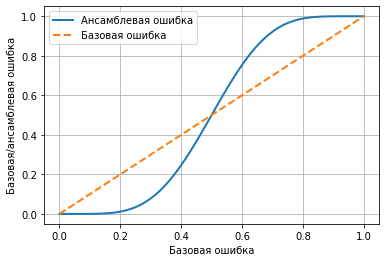

In [2]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

plt.plot(error_range, ens_errors,
         label='Ансамблевая ошибка',
         linewidth=2)
plt.plot(error_range, error_range,
         linestyle='--', label='Базовая ошибка',
         linewidth=2)
plt.xlabel('Базовая ошибка')
plt.ylabel('Базовая/ансамблевая ошибка')
plt.legend(loc='best')
plt.grid()
plt.show()

Характеристика вероятности ошибки, допускаемой ансамблем, всегда лучше такой характеристики индивидуального базового классификатора до тех пор, пока базовые классификаторы работают лучше, чем случайное угадывание (err < 0.5).

### 1. Классификатор с мажоритарным голосованием (голосование большинством)

In [3]:
# Концепция взвешенного большинства голосов
np.argmax(np.bincount([0, 0, 1],
                      weights=[0.2, 0.2, 0.6]))

1

In [4]:
# Взвешенное большинство голосов на основе вероятностей классов

ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
np.argmax(p)

[0.58 0.42]


0

In [5]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

In [6]:
# from sklearn.ensemble import VotingClassifier
# MajorityVoteClassifier in sklearn

Подготовка данных:

In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

iris = load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=1,
                                                    stratify=y)

Перед объединением базовых классификаторов в ансамблевый классификатор оцениваем эффективность каждого классификатора посредством перекрестной проверки по 10 блокам на обучающем наборе:

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2,
                            metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['LogisticRegression', 'DecisionTreeClassifier',
              'KNN']
print('cross val 10:')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print('roc auc: ', scores.mean(), '+-', scores.std(), label)

cross val 10:
roc auc:  0.9166666666666666 +- 0.1536590742882148 LogisticRegression
roc auc:  0.8666666666666668 +- 0.18333333333333332 DecisionTreeClassifier
roc auc:  0.85 +- 0.13333333333333333 KNN


In [9]:
# from sklearn.ensemble import VotingClassifier
# mv_clf = VotingClassifier(estimators=[
#                           ('pipe1', pipe1),
#                           ('clf2', clf2), ('pipe3', pipe3)], voting='soft')
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])


clf_labels += ['Major Vote Classif']

all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print('roc auc: ', scores.mean(), '+-', scores.std(), label)

roc auc:  0.9166666666666666 +- 0.1536590742882148 LogisticRegression
roc auc:  0.8666666666666668 +- 0.18333333333333332 DecisionTreeClassifier
roc auc:  0.85 +- 0.13333333333333333 KNN
roc auc:  0.9833333333333334 +- 0.04999999999999999 Major Vote Classif


In [10]:
# aboba = clone(pipe1)
# aboba.fit(X_train, y_train)
# print(aboba.predict([X_test[0]]))
# print(aboba.predict_proba([X_test[0]])[:, 1])

In [11]:
y_test

array([1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1,
       1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2,
       1, 1, 2, 1, 1, 1])

Построение ROC кривой для всех моделей:

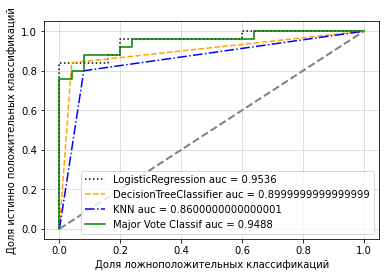

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred, pos_label=2)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} auc = {roc_auc}')
plt.legend(loc='best')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.grid(alpha=0.5)
plt.xlabel('Доля ложноположительных классификаций')
plt.ylabel('Доля истинно положительных классификаций')
plt.show()

Ансамблевый классификатор также хорошо работает на испытательном набор, как и логистическая регрессия. Вероятная причина - высокая дисперсия (чувствительность к тому, как разделяется набор данных).

Построение области принятия решений:

(Стандартизация данных в визуальных целях, чтобы области решений у дерева решений имели тот же самый масштаб)

In [13]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

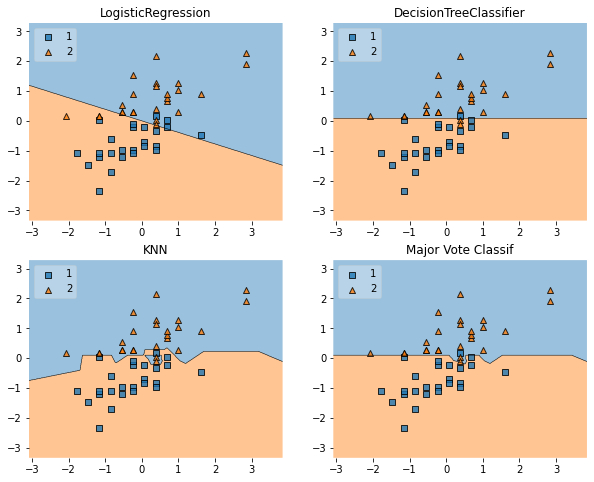

In [14]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10, 8))

for clf, lab, grd in zip(all_clf,
                         clf_labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_train_std, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_std, y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

Настройка гиперпараметров:
- C для логистической регрессии
- глубина дерева

In [15]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [16]:
from sklearn.model_selection import GridSearchCV

params = [{'decisiontreeclassifier__max_depth': [1, 2],
           'pipeline-1__clf__C': [0.001, 0.1, 100.0]}]
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                           

In [17]:
grid.cv_results_

{'mean_fit_time': array([0.00470052, 0.0035008 , 0.0041007 , 0.00340083, 0.00362735,
        0.00450072]),
 'std_fit_time': array([0.00100489, 0.00050006, 0.00030012, 0.00049025, 0.00072243,
        0.00050025]),
 'mean_score_time': array([0.00150068, 0.00130081, 0.00140052, 0.00150046, 0.00130043,
        0.00120065]),
 'std_score_time': array([0.00050008, 0.00045841, 0.00049018, 0.00050035, 0.00045809,
        0.00040038]),
 'param_decisiontreeclassifier__max_depth': masked_array(data=[1, 1, 1, 2, 2, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_pipeline-1__clf__C': masked_array(data=[0.001, 0.1, 100.0, 0.001, 0.1, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'decisiontreeclassifier__max_depth': 1,
   'pipeline-1__clf__C': 0.001},
  {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1},
  {'decisiontr

Вывод различных комбинаций значений гиперпараметров и средние показатели ROC AUC, вычесленные посредством перекрестной проверки по 10 блокам:

In [18]:
for r in range(len(grid.cv_results_['mean_test_score'])):
    print(f"{grid.cv_results_['mean_test_score'][r]} +- ",
          f"{grid.cv_results_['std_test_score'][r]}\n",
          f"{grid.cv_results_['params'][r]}")

0.9833333333333334 +-  0.04999999999999999
 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.9833333333333334 +-  0.04999999999999999
 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.9666666666666668 +-  0.09999999999999998
 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.9833333333333334 +-  0.04999999999999999
 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.9833333333333334 +-  0.04999999999999999
 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.9666666666666668 +-  0.09999999999999998
 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [19]:
print(f'Наилучшие параметры: {grid.best_params_}')

Наилучшие параметры: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [20]:
grid.best_score_

0.9833333333333334

### 2. Bagging - построение ансамбля классификаторов из бутстрэп-образцов

Для подгонки классификаторов в ансамбле вместо использования того же самого обучающего набора производится выборка бутстрэп-образцов (случайных образцов с возвращением) из первоначального обучающего набора.

<img src="pic/bagging.png" width="360"/>

Каждый классификатор получает случайный поднабор образцов из обучающего набора. Каждый поднабор содержит определенную долю дубликатов, а некоторые исходные образцы вообще не появляются в повторно выбранном наборе данных из-за выборки с возвращением. После того, как индивидуальные классификаторы подогнаны к бутстрэп-образцам, прогнозы объединяются с применением мажоритарного голосования.

Случайные леса - это частный случай бэггинга, где при подгонке индвивидуальных деревьев принятия решений также используются случайные поднаборы.

In [21]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np

data = load_wine()
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target'] = data.target + 1
df = df.reindex(columns=['target'] + list(df.columns[:-1]))
df.head()

,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,1,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,1,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,1,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Отбросить класс 1:

In [22]:
df = df[df['target'] != 1]
df.head()

,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
59,2,12.37,0.94,1.36,10.6,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0
60,2,12.33,1.10,2.28,16.0,101.0,2.05,1.09,0.63,0.41,3.27,1.25,1.67,680.0
61,2,12.64,1.36,2.02,16.8,100.0,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450.0
62,2,13.67,1.25,1.92,18.0,94.0,2.10,1.79,0.32,0.73,3.80,1.23,2.46,630.0
63,2,12.37,1.13,2.16,19.0,87.0,3.50,3.10,0.19,1.87,4.45,1.22,2.87,420.0


In [23]:
X = df[['alcohol', 'od280/od315_of_diluted_wines']].values
y = df['target'].values

In [24]:
y

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3])

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=1)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


В ансамбле будут 500 неподрезанных (max_depth=None) деревьев:

In [26]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

Acc для одного дерева:

In [27]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print(f'acc train: {accuracy_score(y_train, y_train_pred)}, ',
      f'acc test: {accuracy_score(y_test, y_test_pred)}')

acc train: 1.0,  acc test: 0.8333333333333334


Acc для бэггинга:

In [28]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

print(f'acc train: {accuracy_score(y_train, y_train_pred)}, ',
      f'acc test: {accuracy_score(y_test, y_test_pred)}')

acc train: 1.0,  acc test: 0.9166666666666666


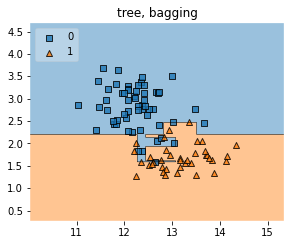

In [29]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10, 8))

for clf, lab, grd in zip([tree, bag],
                         ['tree, bagging'],
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_train, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train, y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

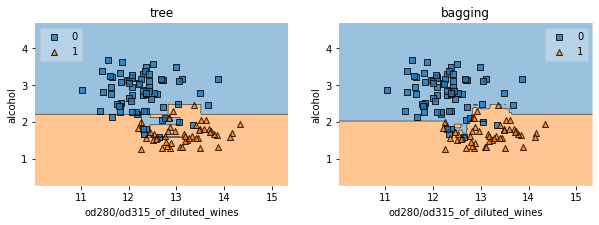

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

fig = plot_decision_regions(X=X, y=y, clf=tree, ax=axes[0], legend=2)
axes[0].set_title('tree')
fig = plot_decision_regions(X=X, y=y, clf=bag, ax=axes[1], legend=1)
axes[1].set_title('bagging')
axes[0].set_xlabel('od280/od315_of_diluted_wines')
axes[0].set_ylabel('alcohol')
axes[1].set_xlabel('od280/od315_of_diluted_wines')
axes[1].set_ylabel('alcohol')
plt.show()

### AdaBoost - adaptive boosting

Использование в своих интересах слабых учеников посредством адаптивного бустинга.

Как работает обычный бустинг:
В отличае от бэггинга алгоритм бустинга применяет случайные поднаборы обучающих образцов, выбранные из обучающего набора данных без возвращения.
1. Производится выборка случайного поднабора обучающих образцов d без возвращения из обучающего набора D для обучения слабого ученика C1.
2. Производится выборка второго случайного поднабора обучающих образцов d2 без возвращения из обучающего набора и добавляются 50% образцов, которые были неправильно классифицированны, для обучения слабого ученика C2.
3. Находится в обучающем наборе D обучающие образцы d3, по которым C1 и C2 расходятся, для обучающего третьего слабого ученика C3.
4. Объеденить слабых учеников C1, C2, C3 посредством мажоритарного голосования.


##### Алгоритм AdaBoost
В отличае от обычного бустинга алгоритм AdaBoost для обучения слабых учеников использует полный обучающий набор, в котором обучающие образцы на кажой итерации заново взвешиваются, чтобы построить более сильный классификатор, обучающийся на ошибках предшествующих слабых учеников в ансамбле.

<img src="pic/adaboost.png" width="360"/>
<img src="pic/adaboost2.png" width="360"/>

In [32]:
# обучение AdaBoostClassifier на 500 пеньках (max_depth=1)
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
print(f'tree acc train: {accuracy_score(y_train, y_train_pred)}, ',
      f'tree acc test: {accuracy_score(y_test, y_test_pred)}')

tree acc train: 0.9157894736842105,  tree acc test: 0.875


Пенёк имеет высокое смещение, т.к. низкая эффективность при обучении.

In [33]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
print(f'adaboost acc train: {accuracy_score(y_train, y_train_pred)}, ',
      f'adaboost acc test: {accuracy_score(y_test, y_test_pred)}')

adaboost acc train: 1.0,  adaboost acc test: 0.9166666666666666


Можно также отметить внесение дополнительной дисперсии за счет попытки снизить смещение модели - больший промежуток между эффективностью при обучении и при тесте.

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

array([[12,  2],
       [ 0, 10]], dtype=int64)

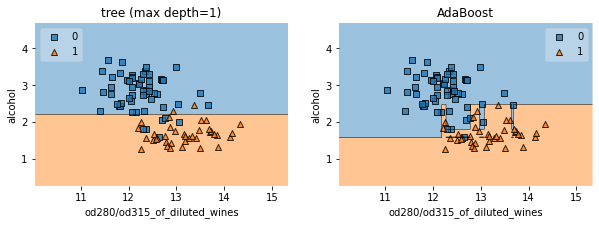

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

fig = plot_decision_regions(X=X_train, y=y_train,
                            clf=tree, ax=axes[0], legend=2)
axes[0].set_title('tree (max depth=1)')
fig = plot_decision_regions(X=X_train, y=y_train,
                            clf=ada, ax=axes[1], legend=1)
axes[1].set_title('AdaBoost')
axes[0].set_xlabel('od280/od315_of_diluted_wines')
axes[0].set_ylabel('alcohol')
axes[1].set_xlabel('od280/od315_of_diluted_wines')
axes[1].set_ylabel('alcohol')
plt.show()

Градиентный бустинг:

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=380, max_depth=1)
gb = gb.fit(X_train, y_train)
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)
print(f'adaboost acc train: {accuracy_score(y_train, y_train_pred)}, ',
      f'adaboost acc test: {accuracy_score(y_test, y_test_pred)}')

adaboost acc train: 1.0,  adaboost acc test: 0.9166666666666666


<AxesSubplot:>

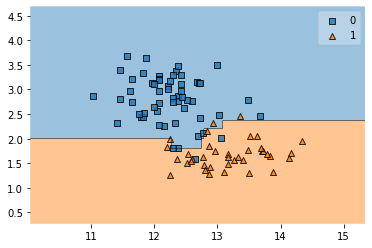

In [62]:
plot_decision_regions(X=X_train, y=y_train, clf=gb)